In [314]:
# import open cv
import cv2
import numpy as np
import matplotlib.pyplot as plt
# import the image
img = cv2.imread('./2.jpeg')  # !Parameter
# convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


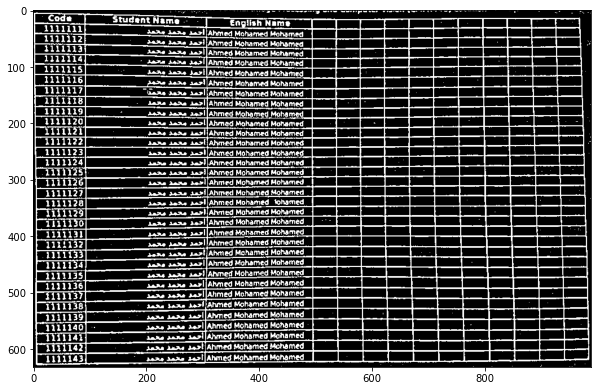

In [315]:
#apply addaptive threshold

img_binary = cv2.adaptiveThreshold(gray, 255,
	cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 4)
# Ilustrate the thresholding
plt.figure(figsize=(10, 10))
plt.imshow(img_binary, cmap='gray')
plt.show()


In [316]:
def transition_per_row(img):
    trans_array = []
    for i in range(img.shape[0]):
        trans = 0
        new_region = True
        for j in range(img.shape[1]):
            if(new_region):
                if(img[i][j]):
                    trans += 1
                    new_region = False
            if(~img[i][j]):
                new_region = True
        trans_array.append(trans)
    trans_median = np.median(trans_array)
    return int(trans_median)


def transition_per_column(img):
    trans_array = []
    for j in range(img.shape[1]):
        trans = 0
        new_region = True
        for i in range(img.shape[0]):
            if(new_region):
                if(img[i][j]):
                    trans += 1
                    new_region = False
            if(~img[i][j]):
                new_region = True
        trans_array.append(trans)
    trans_median = np.median(trans_array)
    return int(trans_median)


35


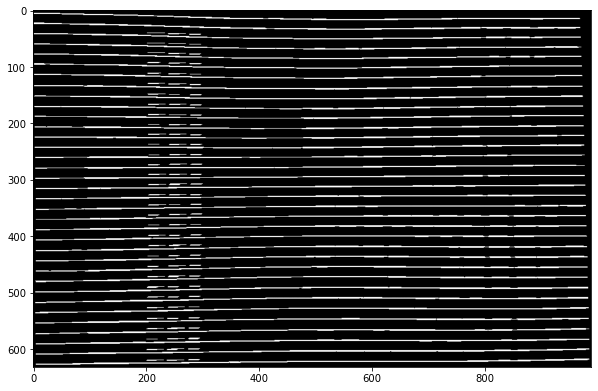

In [317]:
kernal_width = 3  # !Parameter
iterations = 8  # !Parameter
kernel = np.ones((1, kernal_width), np.uint8)
img_horizontal = cv2.erode(img_binary, kernel, iterations=iterations)
img_horizontal = cv2.dilate(img_horizontal, kernel, iterations=iterations)
num_rows = transition_per_column(img_horizontal)
#Ilustrate the horizontal erosion
print(num_rows)
plt.figure(figsize=(10, 10))
plt.imshow(img_horizontal, cmap='gray')
plt.show()


15


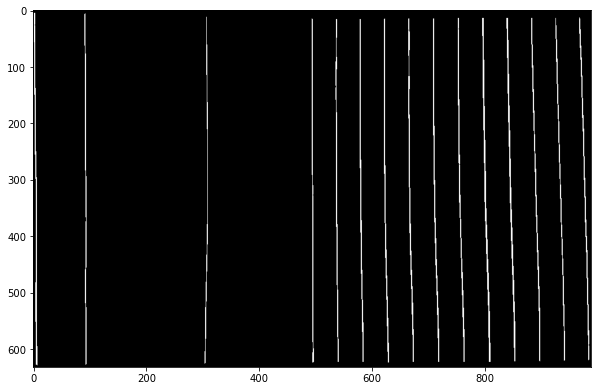

In [318]:
kernal_height = 3  # !Parameter
iterations = 8  # !Parameter
kernel = np.ones((kernal_height, 1), np.uint8)
img_vertical = cv2.erode(img_binary, kernel, iterations=iterations)
img_vertical = cv2.dilate(img_vertical, kernel, iterations=iterations)
num_columns = transition_per_row(img_vertical)
#Ilustrate the vertical erosion
print(num_columns)
plt.figure(figsize=(10, 10))
plt.imshow(img_vertical, cmap='gray')
plt.show()


In [319]:
def get_locations_column(img, num):
    locations_array = []
    for i in range(img.shape[0]):
        locations = []
        trans = 0
        new_region = True
        for j in range(img.shape[1]):
            if(new_region):
                if(img[i][j]):
                    trans += 1
                    locations.append(j)
                    new_region = False
            if(~img[i][j]):
                new_region = True
        if(trans == num):
            locations_array.append(locations)
    locations_array = np.array(locations_array)
    median_location = []
    if (len(locations_array) != 0):
        for k in range(num):
            median_location.append(np.median(locations_array[:, k]))
    return np.array(median_location, dtype=np.int32)


def get_locations_row(img, num):
    locations_array = []
    for j in range(img.shape[1]):
        locations = []
        trans = 0
        new_region = True
        for i in range(img.shape[0]):
            if(new_region):
                if(img[i][j]):
                    trans += 1
                    locations.append(i)
                    new_region = False
            if(~img[i][j]):
                new_region = True
        if(trans == num):
            locations_array.append(locations)
    locations_array = np.array(locations_array)
    median_location = []
    if (len(locations_array) != 0):
        for k in range(num):
            median_location.append(np.median(locations_array[:, k]))
    return np.array(median_location, dtype=np.int32)


In [320]:
locations_columns=get_locations_column(img_vertical,num_columns)
locations_rows=get_locations_row(img_horizontal,num_rows)

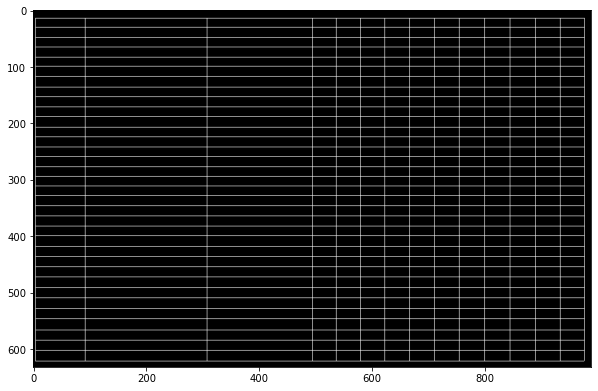

In [321]:
#Ilustrate the table reconstruction
table=np.zeros((img.shape[0],img.shape[1]))
for i in range(num_rows):
	table[int(locations_rows[i]),locations_columns[0]:locations_columns[-1]]=255
for i in range(num_columns):
	table[locations_rows[0]:locations_rows[-1],int(locations_columns[i])]=255
plt.figure(figsize=(10, 10))
plt.imshow(table, cmap='gray')
plt.show()

In [322]:
location_cells_rows = []
for k in range(num_columns-1):
    location_2 = []
    for j in range(locations_columns[k], locations_columns[k+1]+1):
        trans = 0
        location_1 = []
        new_region = True
        for i in range(img_horizontal.shape[0]):
            if(new_region):
                if(img_horizontal[i][j]):
                    trans += 1
                    location_1.append(i)
                    new_region = False
            if(~img_horizontal[i][j]):
                new_region = True
        if(trans == num_rows):
            location_2.append(location_1)
    if(len(location_2) == 0):  # hazard
        location_2.append(locations_rows)
    median_location = np.median(location_2, axis=0)
    median_location = np.array(median_location, dtype=np.int32)
    location_cells_rows.append(median_location)


In [323]:
location_cells_columns = []
for k in range(num_rows-1):
    location_2 = []
    for i in range(locations_rows[k], locations_rows[k+1]+1):
        trans = 0
        location_1 = []
        new_region = True
        for j in range(img_vertical.shape[1]):
            if(new_region):
                if(img_vertical[i][j]):
                    trans += 1
                    location_1.append(j)
                    new_region = False
            if(~img_vertical[i][j]):
                new_region = True
        if(trans == num_columns):
            location_2.append(location_1)
    if(len(location_2) == 0 ):  # hazard
        location_2.append(locations_columns)
    median_location = np.median(location_2, axis=0)
    median_location = np.array(median_location, dtype=np.int32)
    location_cells_columns.append(median_location)


In [324]:
cells_locations = []
for i in range(num_rows-1):
    for j in range(num_columns-1):
        cells_locations.append(
            (location_cells_rows[j][i], location_cells_columns[i][j],
             location_cells_rows[j][i+1], location_cells_columns[i][j+1])
        )


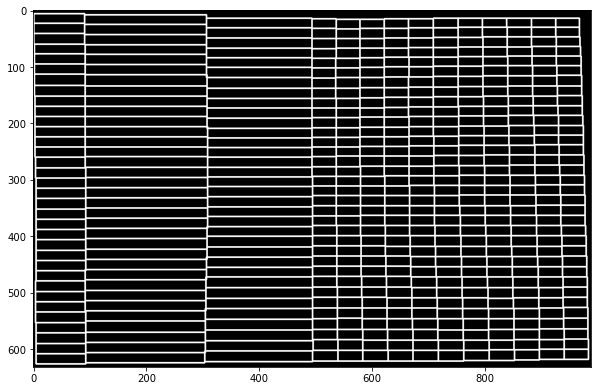

In [325]:
table = np.zeros((img.shape[0], img.shape[1]))
for i in range(len(cells_locations)):
    cv2.rectangle(table, (cells_locations[i][1], cells_locations[i][0]), (
        cells_locations[i][3], cells_locations[i][2]), 255, 2)
plt.figure(figsize=(10, 10))
plt.imshow(table, cmap='gray')
plt.show()


476


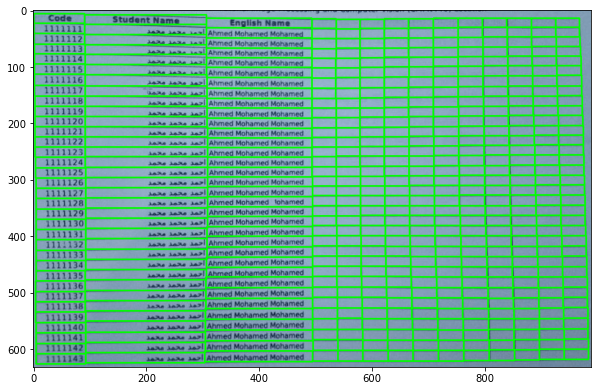

In [326]:
print(len(cells_locations))
img_2 = img.copy()
for i in range(len(cells_locations)):
    cv2.rectangle(img_2, (cells_locations[i][1], cells_locations[i][0]),(cells_locations[i][3], cells_locations[i][2]), (0, 255, 0), 2)
plt.figure(figsize=(10, 10))
plt.imshow(img_2)
plt.show()


In [327]:
cells_content = []
cell_row_content = []
for i in range(len(cells_locations)):
    cell_row_content.append(gray[cells_locations[i][0]:cells_locations[i]
                            [2], cells_locations[i][1]:cells_locations[i][3]])
    if((i+1) % (num_columns-1) == 0):
        cells_content.append(cell_row_content)
        cell_row_content = []


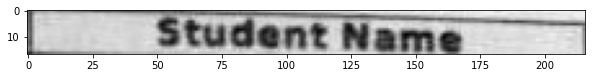

In [328]:
plt.figure(figsize=(10, 10))
plt.imshow(cells_content[0][1], cmap='gray')
plt.show()


## tests

In [329]:
cells_content = []
cell_row_content = []
for i in range(len(cells_locations)):
    cell_row_content.append(gray[cells_locations[i][0]:cells_locations[i]
                            [2], cells_locations[i][1]:cells_locations[i][3]])
    if((i+1) % (num_columns-1) == 0):
        cells_content.append(cell_row_content)
        cell_row_content = []

for i in range(len(cells_content)):
    for j in range(len(cells_content[i])):
        cells_content[i][j] = cv2.threshold(cells_content[i][j], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

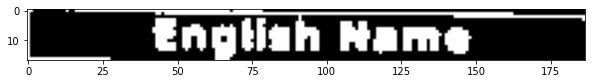

In [330]:
img_with_border = cells_content[0][2].copy()
plt.figure(figsize=(10, 10))
plt.imshow(img_with_border, cmap='gray')
plt.show()


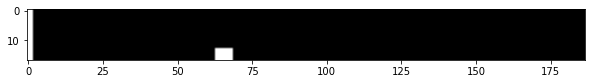

In [331]:
img_with_border_v = cv2.erode(img_with_border, np.ones((15, 1), np.uint8), iterations=1)
img_with_border_v= cv2.dilate(img_with_border_v, np.ones((1, 5), np.uint8), iterations=1)
img_with_border_v = cv2.erode(img_with_border_v, np.ones((1, 4), np.uint8), iterations=1)
plt.figure(figsize=(10, 10))
plt.imshow(img_with_border_v, cmap='gray')
plt.show()

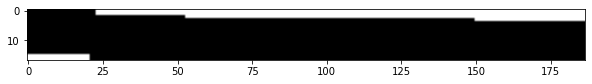

In [332]:
img_with_border_h = cv2.erode(img_with_border, np.ones((1, 15), np.uint8), iterations=1)
img_with_border_h= cv2.dilate(img_with_border_h, np.ones((5, 1), np.uint8), iterations=1)
img_with_border_h = cv2.erode(img_with_border_h, np.ones((3, 1), np.uint8), iterations=1)
plt.figure(figsize=(10, 10))
plt.imshow(img_with_border_h, cmap='gray')
plt.show()

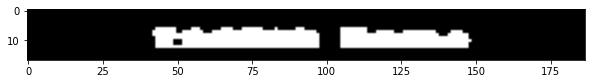

In [333]:
img_without_border = img_with_border.copy()
# upper border
for j in range(img_without_border.shape[1]):
    i = 0
    while(i < img_without_border.shape[0] and img_with_border_h[i][j] != 0):
        img_without_border[i][j] = 0
        i += 1
# lower border
for j in range(img_without_border.shape[1]):
    i = img_without_border.shape[0]-1
    while(i >= 0 and img_with_border_h[i][j] != 0):
        img_without_border[i][j] = 0
        i -= 1
# left border
for i in range(img_without_border.shape[0]):
    j = 0
    while(j < img_without_border.shape[1] and img_with_border_v[i][j] != 0):
        img_without_border[i][j] = 0
        j += 1
# right border
for i in range(img_without_border.shape[0]):
    j = img_without_border.shape[1]-1
    while(j >= 0 and img_with_border_v[i][j] != 0):
        img_without_border[i][j] = 0
        j -= 1
# noise remove
for j in range(img_without_border.shape[1]):
    for i in range(5):
        img_without_border[i][j] = 0
for j in range(img_without_border.shape[1]):
    for i in range(img_without_border.shape[0]-5, img_without_border.shape[0]):
        img_without_border[i][j] = 0
for i in range(img_without_border.shape[0]):
    for j in range(5):
        img_without_border[i][j] = 0
for i in range(img_without_border.shape[0]):
    for j in range(img_without_border.shape[1]-5, img_without_border.shape[1]):
        img_without_border[i][j] = 0

img_without_border = cv2.dilate(
    img_without_border, np.ones((1, 3), np.uint8), iterations=1)
img_without_border = cv2.erode(
    img_without_border, np.ones((1, 3), np.uint8), iterations=1)
img_without_border = cv2.dilate(
    img_without_border, np.ones((2, 1), np.uint8), iterations=1)
img_without_border = cv2.erode(
    img_without_border, np.ones((2, 1), np.uint8), iterations=1)

plt.figure(figsize=(10, 10))
plt.imshow(img_without_border, cmap='gray')
plt.show()


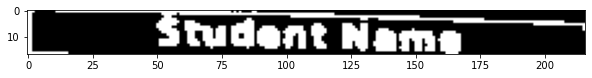

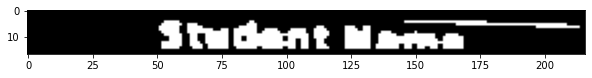

In [334]:
img_with_border = cells_content[0][1].copy()
plt.figure(figsize=(10, 10))
plt.imshow(img_with_border, cmap='gray')
plt.show()
img_with_border_v = cv2.erode(img_with_border, np.ones((15, 1), np.uint8), iterations=1)
img_with_border_v= cv2.dilate(img_with_border_v, np.ones((1, 5), np.uint8), iterations=1)
img_with_border_v = cv2.erode(img_with_border_v, np.ones((1, 4), np.uint8), iterations=1)
img_with_border_h = cv2.erode(img_with_border, np.ones((1, 15), np.uint8), iterations=1)
img_with_border_h= cv2.dilate(img_with_border_h, np.ones((5, 1), np.uint8), iterations=1)
img_with_border_h = cv2.erode(img_with_border_h, np.ones((3, 1), np.uint8), iterations=1)
img_without_border = img_with_border.copy()
# upper border
for j in range(img_without_border.shape[1]):
    i = 0
    while(img_with_border_h[i][j] != 0 and i < img_without_border.shape[0]):
        img_without_border[i][j] = 0
        i += 1
# lower border
for j in range(img_without_border.shape[1]):
    i = img_without_border.shape[0]-1
    while(img_with_border_h[i][j] != 0 and i >= 0):
        img_without_border[i][j] = 0
        i -= 1
# left border
for i in range(img_without_border.shape[0]):
    j = 0
    while(img_with_border_v[i][j] != 0 and j < img_without_border.shape[1]):
        img_without_border[i][j] = 0
        j += 1
# right border
for i in range(img_without_border.shape[0]):
    j = img_without_border.shape[1]-1
    while(img_with_border_v[i][j] != 0 and j >= 0):
        img_without_border[i][j] = 0
        j -= 1
# noise remove
for j in range(img_without_border.shape[1]):
    for i in range(3):
        img_without_border[i][j] = 0
for j in range(img_without_border.shape[1]):
    for i in range(img_without_border.shape[0]-3, img_without_border.shape[0]):
        img_without_border[i][j] = 0
for i in range(img_without_border.shape[0]):
    for j in range(3):
        img_without_border[i][j] = 0
for i in range(img_without_border.shape[0]):
    for j in range(img_without_border.shape[1]-3, img_without_border.shape[1]):
        img_without_border[i][j] = 0

img_without_border = cv2.dilate(img_without_border, np.ones((1, 2), np.uint8), iterations=1)
img_without_border = cv2.erode(img_without_border, np.ones((1, 2), np.uint8), iterations=1)
img_without_border = cv2.dilate(img_without_border, np.ones((2, 1), np.uint8), iterations=1)
img_without_border = cv2.erode(img_without_border, np.ones((2, 1), np.uint8), iterations=1)
plt.figure(figsize=(10, 10))
plt.imshow(img_without_border, cmap='gray')
plt.show()
